In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from math import exp


def genReward(u, s):
    #generate state action value
    return np.random.normal(u, s)

def action_value_estimate(n):
    Q_a = sum(n)/len(n)
    return Q_a

In [17]:
class bandits():
    def __init__(self, arms, init):
        self.arms = arms
        self.rewards = [genReward(3,1) for i in range(arms)]
        self.av_hist = defaultdict(list)
        self.Q_a = [init for i in range(arms)]
        self.a_hist = []
        self.reward_t = []
        self.reward_max = max(self.rewards)
    def action_value_epsilon_greedy(self, iterations, epsilon, sm):
        #epsilon greedy algorithm with univariate or boltzmann selection
        for i in range(iterations):
            #Action Selection
            if np.random.choice(range(100)) <= epsilon*100:
                #random or sm
                if sm == 0 or len(self.Q_a) == 0:
                    #sample using univariate
                    a = np.random.choice(range(self.arms))
                else:
                    #sample using boltzmann distribution
                    tau =  .5
                    gibbs_prob = []
                    denom = 0
                    #denominator for boltzmann distribution
                    for x in range(len(self.Q_a)):
                        denom += exp(self.Q_a[x]/tau)
                    #create sampling probability for each action value in Q_a
                    for y in range(len(self.Q_a)):
                        gibbs_prob.append(exp(self.Q_a[y]/tau)/denom)
                    #sample the action number using the constructed gibbs distribution
                    a = np.random.choice(range(self.arms), p = gibbs_prob)
            else:
                #greedy
                a = self.Q_a.index(max(self.Q_a))
            #Take action
            #Reward for action a
            r = self.rewards[a]
            #Append reward to award history vector
            self.reward_t.append(r)
            #Append reward from action 'a' in action value history
            self.av_hist[a].append(r)
            #Use action value history for 'a' to create average action value of 'a' (for stochastic rewards)
            self.Q_a[a] = action_value_estimate(self.av_hist[a])
        #generate average rewards for each 'play' = t
        self.avg_reward_t = [0 for i in range(iterations)]
        for i in range(len(self.reward_t)):
            self.avg_reward_t[i] = sum(self.reward_t[:i])/(i+1)
            
        return np.array(self.avg_reward_t)/self.reward_max
    
    def reinforcement_comparison(self, iterations, alpha, beta):
        #reference reward / reward estimate
        ref_reward = 0
        #preference values
        preferences = [0 for i in range(self.arms)]
        
        for i in range(iterations):
            gibbs_prob = []
            #selection criteria using soft max method with boltzmann
            denom = 0
            for i in range(len(preferences)):
                denom += exp(preferences[i])
            for y in range(len(preferences)):
                gibbs_prob.append(exp(preferences[y])/denom)
            a = np.random.choice(range(self.arms), p = gibbs_prob)
            
            #Take Action
            #Reward for action a
            r = self.rewards[a]
            #Append reward to award history vector
            self.reward_t.append(r)
            #Append reward from action 'a' in action value history
            self.av_hist[a].append(r)
            
            #update preference vector given action a is selected
            if beta == 'step':
                preferences[a] = preferences[a] + (1/(i+1))*(self.rewards[a] - ref_reward)
            else:
                preferences[a] = preferences[a] + beta*(self.rewards[a] - ref_reward)
            
            #update refernce reward
            if beta == 'step':
                ref_reward = ref_reward + (1/(i+1))*(self.rewards[a] - ref_reward)
            else:
                ref_reward = ref_reward + alpha*(self.rewards[a] - ref_reward)
            
            #generate average rewards for each 'play' = t
            self.avg_reward_t = [0 for i in range(iterations)]
            for i in range(len(self.reward_t)):
                self.avg_reward_t[i] = sum(self.reward_t[:i])/(i+1)
        return np.array(self.avg_reward_t)/self.reward_max
    
    def pursuit(self, iterations, beta):
        a = 0
        probabilities = [1/self.arms for i in range(self.arms)]
        for i in range(iterations):
            ###select action
            a = np.random.choice(range(self.arms), p = probabilities)
            #Take Action
            ###Reward for action a
            r = self.rewards[a]
            #Append reward to award history vector
            self.reward_t.append(r)
            #Append reward from action 'a' in action value history
            self.av_hist[a].append(r) 
            #Use action value history for 'a' to create average action value of 'a' (for stochastic rewards)
            self.Q_a[a] = action_value_estimate(self.av_hist[a])
            ###Adjust action preferences / probabilities
            a_max = self.Q_a.index(max(self.Q_a))
            probabilities[a_max] = probabilities[a_max] + beta - beta*probabilities[a_max]
            for i in range(len(probabilities)):
                if i != a_max:
                    probabilities[i] = probabilities[i] - beta*probabilities[i]
            #return da stuff
            self.avg_reward_t = [0 for i in range(iterations)]
            for i in range(len(self.reward_t)):
                self.avg_reward_t[i] = sum(self.reward_t[:i])/(i+1)
        return np.array(self.avg_reward_t)/self.reward_max
    


Text(0, 0.5, 'Avg % of Optimal at Play')

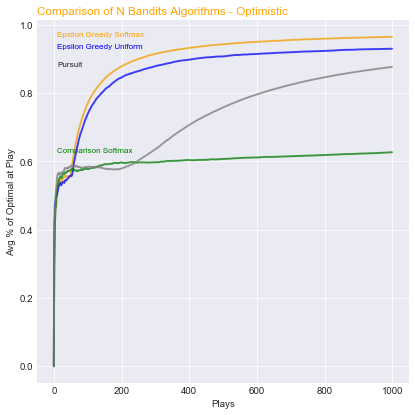

In [18]:

###MAIN###
##parameters
horizon = 1000
epsilon = .1
arms = 50
init = 10
episodes = 10

#Epsilon Greedy with Softmax/Boltzmann
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.action_value_epsilon_greedy(horizon, epsilon,1)
    #update average Q
    if k == 0:
        avg_pct_optimal_1 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_1 = avg_pct_optimal_1 + (pct_optimal - avg_pct_optimal_1) / (k+1)
        
#Epsilon Greedy with uniform selection criteria
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.action_value_epsilon_greedy(horizon, epsilon, 0)
    #update average Q
    if k == 0:
        avg_pct_optimal_2 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_2= avg_pct_optimal_2 + (pct_optimal - avg_pct_optimal_2) / (k+1)
        
#Reinforfement Comparison with Softmax
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.reinforcement_comparison(horizon, .1, 'step')
    #update average Q
    if k == 0:
        avg_pct_optimal_3 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_3= avg_pct_optimal_3 + (pct_optimal - avg_pct_optimal_3) / (k+1)

#Pursuit
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.pursuit(horizon, .01)
    #update average Q
    if k == 0:
        avg_pct_optimal_4 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_4= avg_pct_optimal_4 + (pct_optimal - avg_pct_optimal_4) / (k+1)


##plotting
#df
df = pd.DataFrame({'x': range(horizon), 'y1': avg_pct_optimal_1, 'y2': avg_pct_optimal_2, 'y3': avg_pct_optimal_3,'y4': avg_pct_optimal_4})
#style
plt.style.use('seaborn-darkgrid')
my_dpi=70
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

#plt parameters
for column in df.drop('x', axis=1):
   plt.plot(df['x'], df[column], marker='', color='grey', linewidth=1, alpha=0.4)
   
# Now re do the interesting curve, but biger with distinct color
plt.plot(df['x'], df['y1'], marker='', color='orange', linewidth=2, alpha=0.7)
plt.plot(df['x'], df['y2'], marker='', color='blue', linewidth=2, alpha=0.7)
plt.plot(df['x'], df['y3'], marker='', color='green', linewidth=2, alpha=0.7)
plt.plot(df['x'], df['y4'], marker='', color='gray', linewidth=2, alpha=0.7)

#Line annotation
plt.text(10.2, df.y1.tail(1), 'Epsilon Greedy Softmax', horizontalalignment='left', size='small', color='orange')
plt.text(10.2, df.y2.tail(1), 'Epsilon Greedy Uniform', horizontalalignment='left', size='small', color='blue')
plt.text(10.2, df.y3.tail(1), 'Comparison Softmax', horizontalalignment='left', size='small', color='green')
plt.text(10.2, df.y4.tail(1), 'Pursuit', horizontalalignment='left', size='small')

#plt titles
plt.title('Comparison of N Bandits Algorithms - Optimistic',loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel('Plays')
plt.ylabel('Avg % of Optimal at Play')



Text(0, 0.5, 'Avg % of Optimal at Play')

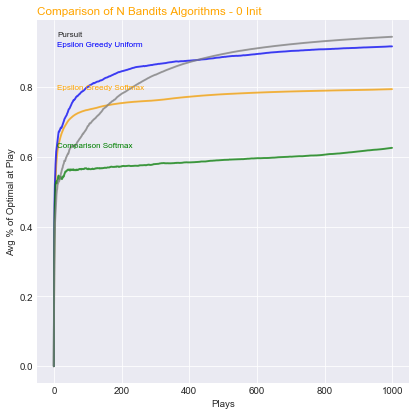

In [19]:

###MAIN###
##parameters
horizon = 1000
epsilon = .1
arms = 50
init = 0
episodes = 10

#Epsilon Greedy with Softmax/Boltzmann
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.action_value_epsilon_greedy(horizon, epsilon,1)
    #update average Q
    if k == 0:
        avg_pct_optimal_1 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_1 = avg_pct_optimal_1 + (pct_optimal - avg_pct_optimal_1) / (k+1)
        
#Epsilon Greedy with uniform selection criteria
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.action_value_epsilon_greedy(horizon, epsilon, 0)
    #update average Q
    if k == 0:
        avg_pct_optimal_2 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_2= avg_pct_optimal_2 + (pct_optimal - avg_pct_optimal_2) / (k+1)
        
#Reinforfement Comparison with Softmax
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.reinforcement_comparison(horizon, .1, 'step')
    #update average Q
    if k == 0:
        avg_pct_optimal_3 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_3= avg_pct_optimal_3 + (pct_optimal - avg_pct_optimal_3) / (k+1)

#Pursuit
for k in range(episodes): 
    bandito = bandits(arms, init)
    pct_optimal = bandito.pursuit(horizon, .01)
    #update average Q
    if k == 0:
        avg_pct_optimal_4 = pct_optimal
    else:
    #increment avg pct of optimal per play
        avg_pct_optimal_4= avg_pct_optimal_4 + (pct_optimal - avg_pct_optimal_4) / (k+1)


##plotting
#df
df = pd.DataFrame({'x': range(horizon), 'y1': avg_pct_optimal_1, 'y2': avg_pct_optimal_2, 'y3': avg_pct_optimal_3,'y4': avg_pct_optimal_4})
#style
plt.style.use('seaborn-darkgrid')
my_dpi=70
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

#plt parameters
for column in df.drop('x', axis=1):
   plt.plot(df['x'], df[column], marker='', color='grey', linewidth=1, alpha=0.4)
   
# Now re do the interesting curve, but biger with distinct color
plt.plot(df['x'], df['y1'], marker='', color='orange', linewidth=2, alpha=0.7)
plt.plot(df['x'], df['y2'], marker='', color='blue', linewidth=2, alpha=0.7)
plt.plot(df['x'], df['y3'], marker='', color='green', linewidth=2, alpha=0.7)
plt.plot(df['x'], df['y4'], marker='', color='gray', linewidth=2, alpha=0.7)

#Line annotation
plt.text(10.2, df.y1.tail(1), 'Epsilon Greedy Softmax', horizontalalignment='left', size='small', color='orange')
plt.text(10.2, df.y2.tail(1), 'Epsilon Greedy Uniform', horizontalalignment='left', size='small', color='blue')
plt.text(10.2, df.y3.tail(1), 'Comparison Softmax', horizontalalignment='left', size='small', color='green')
plt.text(10.2, df.y4.tail(1), 'Pursuit', horizontalalignment='left', size='small')

#plt titles
plt.title('Comparison of N Bandits Algorithms - 0 Init',loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel('Plays')
plt.ylabel('Avg % of Optimal at Play')

